# Computation of Magnetic Dipole Vector

This calculation is based off equations 3 - 7 from the paper [Magnetograph Saturation and the Open Flux Problem](https://iopscience.iop.org/article/10.3847/1538-4357/ac4491/pdf).

The dipole vector looks like: $(H_1, H_2, D_{ax})$ defined below:  

$D_{ax} = \frac{3}{4 \pi} \int B_r(R_\odot\, \theta, \Phi, t) \sin \theta d\Omega$ [Equation 4]   

$H_1(t) = \frac{3}{4 \pi} \int B_r(R_\odot\, \theta, \Phi, t) \cos \theta \cos \Phi d\Omega$ [Equation 6]

$H_1(t) = \frac{3}{4 \pi} \int B_r(R_\odot\, \theta, \Phi, t) \cos \theta \sin \Phi d\Omega$ [Equation 7]



In [15]:
import scipy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

import pfss_funcs as pfs


In [19]:
def get_map_scales(smap):
    """
    compute the solar X and solar Y 2D pixel scale arrays from a sunpy map object
    - If the image has been rotated to solar north up, then the x and y scales will
      be in the helioprojective cartesian system with units of [Rs].
    Parameters
    ----------
    smap: Sunpy map object
    Returns
    -------
    x: array of x coordinates in helioprojective cartesian system
    y: array of y coordinates in helioprojective cartesian system
    """

    header = smap.fits_header

    # pixel array
    axis1 = np.linspace(1, header['NAXIS1'], header['NAXIS1']) - header['CRPIX1']
    axis2 = np.linspace(1, header['NAXIS2'], header['NAXIS2']) - header['CRPIX2']

    # pixel offset from center of image, x,y
    x, y = np.meshgrid(axis1, axis2)

    return x, y

def coordinates(smap):
    """
    calculate array of mu values and cartesian
    coordinates for image
    Parameters
    ----------
    smap: Sunpy map object
    Returns
    -------
    x: array of x coordinates in helioprojective cartesian system
    y: array of y coordinates in helioprojective cartesian system
    pd: array of pixel distances
    r: array of solar radius values
    d: observer distance from sun in solar radii
    mu: array of mu values
    """

    # distance of observer to sun in solar radii
    d = smap.fits_header['DSUN_OBS'] / smap.fits_header['RSUN_REF']

    # focal length in pixels
    f = 180. * 3600. / np.pi / smap.fits_header['CDELT1']

    # get cartesian x, y map scales
    x, y = get_map_scales(smap)

    # distance (in pixels) to pixel
    pd = np.sqrt(x ** 2 + y ** 2)

    # distance (in solar r) to pixel
    pr = f * f * pd * pd + pd ** 4 - d * d * pd ** 4 + 0.J
    r = (d * f * pd - np.sqrt(pr)) / (f * f + pd * pd)

    # separate complex parts
    r = r.real

    # get mu array
    pr = 1 - r ** 2 + 0.J
    cos_alpha = (np.sqrt(pr)).real
    sin_alpha = r.real
    cos_theta = ((d - np.sqrt(pr)) / np.sqrt(r ** 2 + (d - np.sqrt(pr)) ** 2)).real
    sin_theta = (np.sqrt(1 - cos_theta ** 2)).real
    mu = cos_alpha * cos_theta - sin_alpha * sin_theta

    return x, y, pd, r, d, mu


In [44]:
# read in a pickle file
psp = pickle.load(open("2018-08-15.pkl","rb"))
mag = psp['Magnetogram']

# find number of points in magnetogram to create theta and phi grid
y, x = np.shape(mag)

# this magnetic field data goes from -90 to 90 in the theta direction, and 0 to 360 in the phi direction
phi, theta = np.meshgrid(np.linspace(0,360,x)*u.deg,
                        np.linspace(-90,90,y)*u.deg)

In [50]:
# axial dipole strength

Dax = np.nansum(mag * np.sin(theta)) 

In [51]:
Dax


<Quantity 0.00051993>

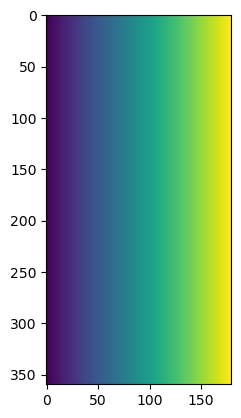